In [53]:
# Horrible CT-HYB
# Authors: Markus Wallerberger, Patrik Gunacker
# Permission to use for anything but serious science.

In [54]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as pl

In [55]:
u = 2.00
mu = 1.00
beta = 10.0

In [56]:
def hyb_pos(cspin, aspin, tau):
    global beta
    cspin, aspin, tau = np.broadcast_arrays(cspin, aspin, tau)
    return np.where(cspin == aspin, 
                    np.exp(-tau) + np.exp(-beta+tau), 
                    0
                   )

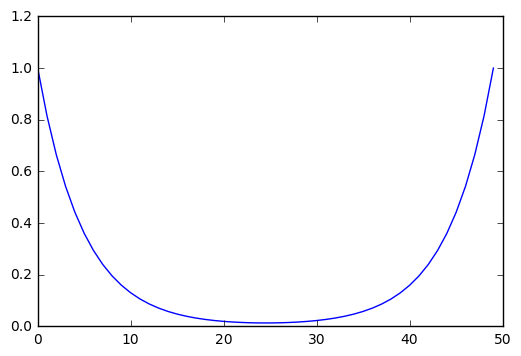

In [57]:
pl.plot(hyb_pos(0, 0, np.linspace(0, beta)))

In [58]:
c_up = np.array([
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
      ])
c_down = np.array([
        [0, 0, 1, 0],
        [0, 0, 0,-1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
      ])
cdagger_up = c_up.T
cdagger_down = c_down.T

In [59]:
class Operator:
    def __init__(self, spin, typ, tau):
        self.spin = spin
        self.typ = typ
        self.tau = tau
        self.matrix = {
                ('cdagger', 0): cdagger_up,
                ('cdagger', 1): cdagger_down,
                ('c', 0): c_up,
                ('c', 1): c_down
            }[(typ, spin)]

In [60]:
h = - mu * cdagger_up.dot(c_up) - mu * cdagger_down.dot(c_down) \
    + u * cdagger_up.dot(c_up).dot(cdagger_down).dot(c_down)

In [61]:
def evolve(h, tau):
    return np.diag(np.exp(-h.diagonal() * tau))

In [62]:
def get_local_weight(opers):
    global h
    last_tau = 0
    s = np.eye(4)
    for oper in opers:
        s = evolve(h, oper.tau - last_tau).dot(s)
        s = oper.matrix.dot(s)
        last_tau = oper.tau
    s = evolve(h, beta - last_tau).dot(s)
    return s.trace()

In [63]:
def get_hyb_antiperiodic(cspin, aspin, tau):
    global beta
    cspin, aspin, tau = np.broadcast_arrays(cspin, aspin, tau)
    where_pos = tau >= 0
    vals = np.empty_like(tau)
    vals[where_pos] = hyb_pos(cspin[where_pos], aspin[where_pos],
                              tau[where_pos])
    vals[~where_pos] = -hyb_pos(cspin[~where_pos], aspin[~where_pos],
                                tau[~where_pos] + beta)
    return vals

In [64]:
def get_hyb_matrix(opers):
    opers = sorted(opers, key=lambda op: op.typ)
    spin = np.asarray([op.spin for op in opers])
    tau = np.asarray([op.tau for op in opers])
    nopershalf = spin.size//2
    hyb_matrix = get_hyb_antiperiodic(
        spin[nopershalf:, np.newaxis],
        spin[np.newaxis, :nopershalf],
        tau[nopershalf:, np.newaxis] - tau[np.newaxis, :nopershalf]
        )
    return hyb_matrix, tau, spin

In [65]:
def get_bath_weight(opers):
    try:
        hyb_matrix, tau, spin = get_hyb_matrix(opers)
        return np.linalg.det(hyb_matrix)
    except np.linalg.LinAlgError:
        if np.size(opers): raise
        return 1.

In [66]:
def add_pair(spin, tau1, tau2):
    global opers, prop_opers, prop_weight
    prop_opers = list(opers) + [
                    Operator(spin, 'c', tau1),
                    Operator(spin, 'cdagger', tau2)
                    ]
    prop_opers = sorted(prop_opers, key=lambda op: op.tau)
    prop_weight = get_local_weight(prop_opers)
    if prop_weight != 0:
        prop_weight *= get_bath_weight(prop_opers)
    # Ignore sign problem
    prop_weight = np.abs(prop_weight)

In [67]:
def remove_pair(index1, index2):
    # Convert bath to local index
    global opers, prop_opers, prop_weight
    lookup = np.argsort([op.typ for op in opers], kind='mergesort')
    index1 = lookup[index1]
    index2 = lookup[len(opers)//2 + index2]
    prop_opers = np.delete(opers, [index1, index2])
    prop_weight = get_local_weight(prop_opers)
    if prop_weight != 0:
        prop_weight *= get_bath_weight(prop_opers)
    # Ignore sign problem
    prop_weight = np.abs(prop_weight)

In [68]:
def qmc_step(rng):
    global beta, opers, prop_weight, weight, prop_opers
    move_typ = rng.randint(0, 2)
    k = len(opers)//2
    if move_typ == 0:
        # INSERT
        tau1, tau2 = rng.rand(2) * beta
        spin = rng.randint(0, 2)
        add_pair(spin, tau1, tau2)
        ratio = (2 * beta**2)/(k + 1)**2
    else:
        # REMOVE
        if not k:
            return        
        index1, index2 = rng.randint(0, k, 2)
        remove_pair(index1, index2)
        ratio = k**2/(2 * beta**2)
    ratio *= np.abs(prop_weight/weight)
    
    if rng.rand() < ratio:
        weight = prop_weight
        opers = list(prop_opers)

In [69]:
def meas_gtau():
    global opers, gtau
    hyb_matrix, tau, spin = get_hyb_matrix(opers)
    nopershalf = tau.size//2
    inv_matrix = np.linalg.inv(hyb_matrix)
    indices = spin[nopershalf:, np.newaxis] * 2 * gtau.shape[-1] + \
              spin[np.newaxis, :nopershalf] * gtau.shape[-1] + \
              (tau[nopershalf:, np.newaxis] - 
               tau[np.newaxis, :nopershalf] + beta) * gtau.shape[-1]/(2*beta)
    gtau += np.bincount(np.asarray(indices,int).ravel(), weights=inv_matrix.T.ravel(),
                        minlength=gtau.size).reshape(gtau.shape)

In [70]:
opers = []
weight = get_local_weight([])
prop_opers = []
prop_weight = 1.0

gtau = np.zeros((2, 2, 100))
histo = np.zeros(1000)

In [71]:
nmeas = 10000

In [72]:
rng = np.random.RandomState()
for _ in xrange(nmeas):
    for _ in xrange(10):
        qmc_step(rng)
    histo[len(opers)//2] += 1
    meas_gtau()

In [73]:
ntau = gtau.shape[-1]//2
gtau = gtau / (nmeas * beta * (beta/ntau))
gtau = -gtau[0,0,:ntau] + gtau[0,0,ntau:]

In [74]:
histo /= nmeas

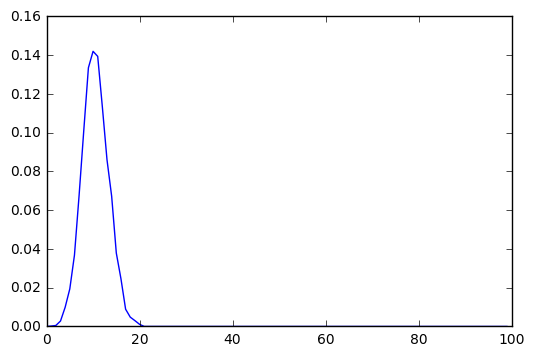

In [75]:
pl.plot(histo[:100])

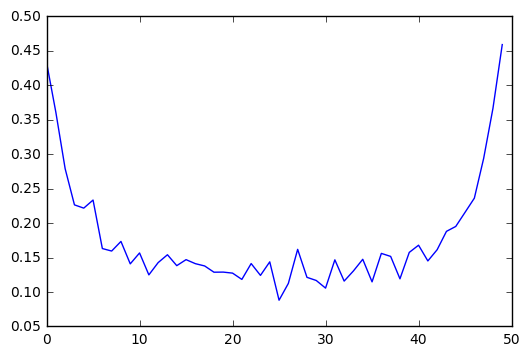

In [76]:
pl.plot(gtau)